## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# setup codes
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import calibration # our calibration module
from detector import LaneDetector # our lane detector
%matplotlib inline

# define a plot all images function
def plotImages(images, rows, columns, cmap = 'viridis'):
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap)

## Perform Camera Calibration
Perform calibration with provided checkerboard images.
Apply distortion correction to one of the sample images.

[[1.15777818e+03 0.00000000e+00 6.67113857e+02]
 [0.00000000e+00 1.15282217e+03 3.86124583e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]
[[-5.47315873e-01 -1.47765639e+00  9.73444509e+02]
 [ 2.01930440e-16 -1.94472580e+00  8.80960787e+02]
 [-0.00000000e+00 -2.39051271e-03  1.00000000e+00]]


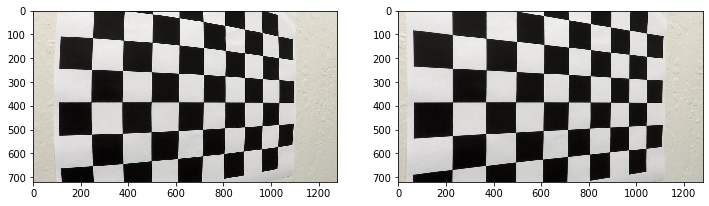

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = []
imagesPath = glob.glob('../camera_cal/calibration*.jpg')
for path in imagesPath:
    images.append(mpimg.imread(path))

# call camera calibration function
camMatrix, distCoeffs = calibration.calibrate(images, (9,6), objp)
print(camMatrix)
print(distCoeffs)

# correct a raw image
imagePlot = []
sampleImage = images[0]
undistortedImage = calibration.undistort(sampleImage, camMatrix, distCoeffs)
imagePlot.append(sampleImage)
imagePlot.append(undistortedImage)
plotImages(imagePlot, 1, 2)
mpimg.imsave('../output_images/calibration1.jpg', imagePlot[0])
mpimg.imsave('../output_images/calibration2.jpg', imagePlot[1])

# create the the lane detector object
laneDetector = LaneDetector(sampleImage, camMatrix, distCoeffs)
print(laneDetector.M)

## Preprocess

First load in all test images. While loading, we also apply the distortion correct with the parameters we computed in the previous section.

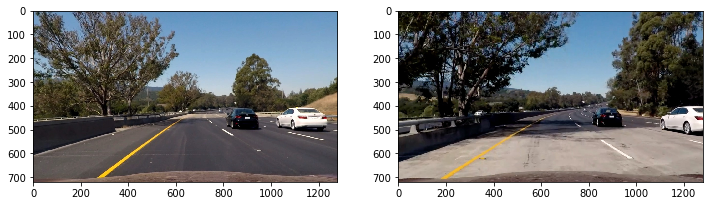

In [3]:
images = []
imagesPath = glob.glob('../test_images/*.jpg')
for path in imagesPath[0:2]:
    images.append(calibration.undistort(mpimg.imread(path), camMatrix, distCoeffs)) # load and correct
plotImages(images, 1, 2)
mpimg.imsave('../output_images/original1.jpg', images[0])
mpimg.imsave('../output_images/original2.jpg', images[1])

In project 1, we used a combination of yellow and white color thresholding. In this project, we try to add an additional thresholding in the LAB space. We know that the segmentation of lane is most promising in the B channel. So we generate a binary image from the B channel.

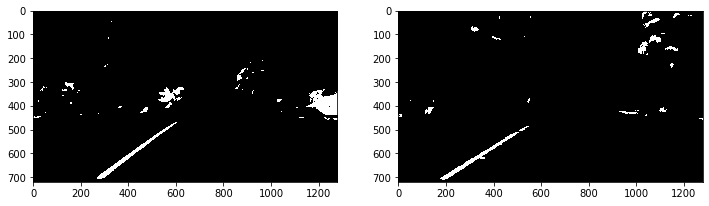

In [4]:
lab = []
bThreshold = [150, 255]
for image in images:
    imageLAB = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    imageB = imageLAB[:,:,2]
    maskB = np.zeros_like(imageB)
    maskB[(imageB >= bThreshold[0]) & (imageB <= bThreshold[1])] = 255
    lab.append(maskB)

mpimg.imsave('../output_images/lab1.jpg', lab[0], cmap = 'gray')
mpimg.imsave('../output_images/lab2.jpg', lab[1], cmap = 'gray')
plotImages(lab, 1, 2, cmap = 'gray')

We also use the yellow white color thresholding the same as we did in project 1.

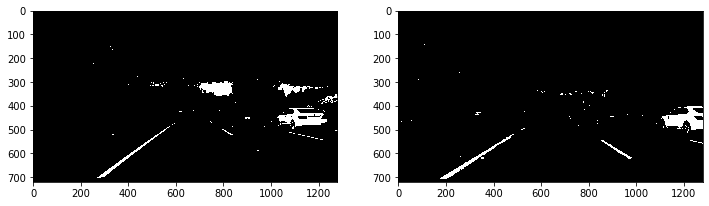

In [5]:
lowerWhite = np.array([185, 185, 185])
upperWhite = np.array([255, 255, 255])
lowerYellow = np.array([150, 150, 0])
upperYellow = np.array([255, 255, 120])

colorYW = []
for image in images:
    maskW = cv2.inRange(image, lowerWhite, upperWhite)
    maskY = cv2.inRange(image, lowerYellow, upperYellow)
    # Combine yellow white mask
    maskWY = cv2.add(maskW, maskY)
    colorYW.append(maskWY)

mpimg.imsave('../output_images/yw1.jpg', colorYW[0], cmap = 'gray')
mpimg.imsave('../output_images/yw2.jpg', colorYW[1], cmap = 'gray')
plotImages(colorYW, 1, 2, cmap = 'gray')

Now we have two binary images, we combine them to form our final image for lane detection.

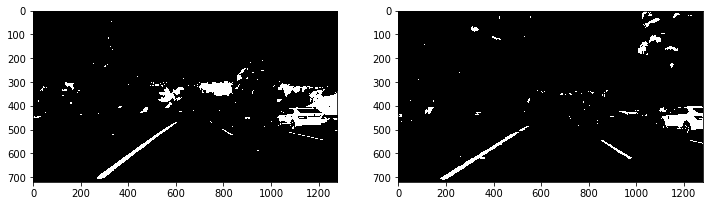

In [6]:
combined = []
for mask1, mask2 in zip(lab, colorYW):
    combined.append(cv2.add(mask1, mask2))

mpimg.imsave('../output_images/combined1.jpg', combined[0], cmap = 'gray')
mpimg.imsave('../output_images/combined2.jpg', combined[1], cmap = 'gray')
plotImages(combined, 1, 2, cmap = 'gray')

We define a region of interest, visualize it first on the orginal image. We then use that region of interest to compute a perspective transform. With the transform, we warp input images into the "bird's view".

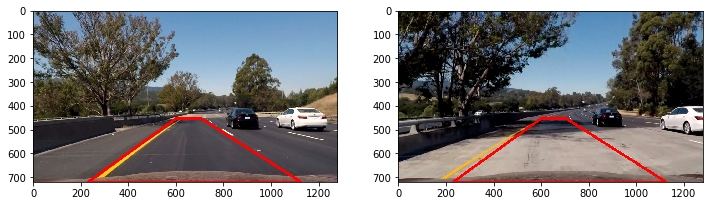

In [7]:
imgSize = images[0].shape[0:2]
roi = np.int32([
    [imgSize[1] * 0.47, imgSize[0] * 0.63], 
    [imgSize[1] - imgSize[1] * 0.45, imgSize[0] * 0.63], 
    [imgSize[1] - imgSize[1] * 0.12, imgSize[0]],
    [imgSize[1] * 0.18, imgSize[0]]])

roiDraw = []
for image in images:
    vertices = roi
    img = image.copy()
    cv2.line(img, (roi[0][0], roi[0][1]), (roi[1][0], roi[1][1]), (255, 0, 0), 10)
    cv2.line(img, (roi[2][0], roi[2][1]), (roi[1][0], roi[1][1]), (255, 0, 0), 10)
    cv2.line(img, (roi[2][0], roi[2][1]), (roi[3][0], roi[3][1]), (255, 0, 0), 10)
    cv2.line(img, (roi[0][0], roi[0][1]), (roi[3][0], roi[3][1]), (255, 0, 0), 10)
    roiDraw.append(img)

mpimg.imsave('../output_images/roi1.jpg', roiDraw[0])
mpimg.imsave('../output_images/roi2.jpg', roiDraw[1])
plotImages(roiDraw, 1, 2)  

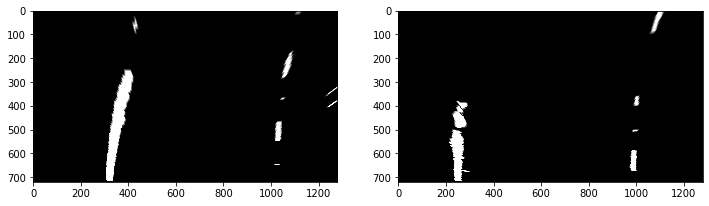

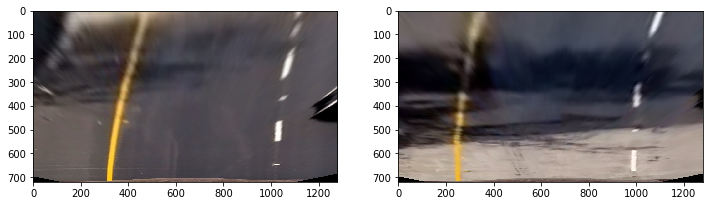

In [8]:
def getWarpTransform(image, roi, offset):
    img_size = (image.shape[1], image.shape[0])
    src = np.float32(roi)
    dst = np.float32([
        [offset, 0], 
        [img_size[0]-offset, 0], 
        [img_size[0]-offset, img_size[1]], 
        [offset, img_size[1]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    return M

def warpImage(image, M):
    img_size = (image.shape[1], image.shape[0])
    # Warp the image using OpenCV warpPerspective()
    imageWarped = cv2.warpPerspective(image, M, img_size)
    return imageWarped

M = getWarpTransform(images[0], roi, 300)
warpBinary = []
warpOriginal = []
for image in combined:
    warpBinary.append(warpImage(image, M))
    
for image in images:
    warpOriginal.append(warpImage(image, M))

mpimg.imsave('../output_images/birdviewbinary1.jpg', warpBinary[0], cmap = 'gray')
mpimg.imsave('../output_images/birdviewbinary2.jpg', warpBinary[1], cmap = 'gray')
mpimg.imsave('../output_images/birdvieworiginal1.jpg', warpOriginal[0])
mpimg.imsave('../output_images/birdvieworiginal2.jpg', warpOriginal[1])
plotImages(warpBinary, 1, 2, cmap = 'gray')
plotImages(warpOriginal, 1, 2)

## Lane Detection Sliding Window & Polynomial Neighbor

After getting the warped image, we perform the sliding window method and polynomialline neighbor search method to detect lane from bottom to top. Use the codes in lecture quiz. We integeate the codes in to our LaneDetector calss.

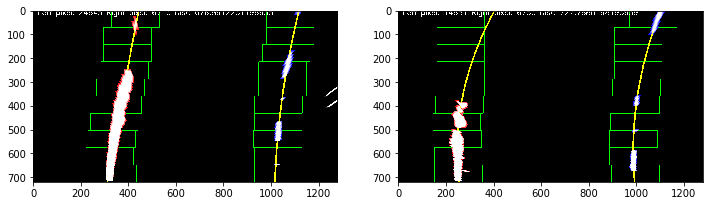

In [9]:
slidingWindow = []
for image in warpBinary:
    valid, left_fit, right_fit, numLeft, numRight, dist, out_img = laneDetector.find_lane_init(image)
    slidingWindow.append(out_img)

mpimg.imsave('../output_images/slidingwindow1.jpg', slidingWindow[0])
mpimg.imsave('../output_images/slidingwindow2.jpg', slidingWindow[1])
plotImages(slidingWindow, 1, 2)

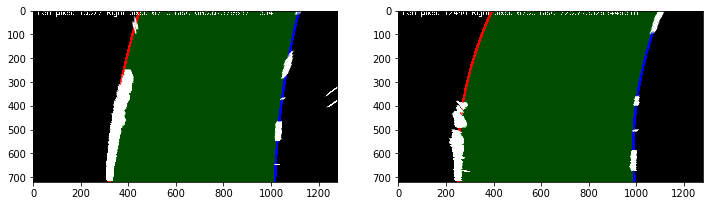

In [10]:
polyLine = []
for image in warpBinary:
    valid, left_fit, right_fit, numLeft, numRight, dist, out_img = laneDetector.search_around_poly(image, left_fit, right_fit)
    polyLine.append(out_img)

mpimg.imsave('../output_images/poly1.jpg', polyLine[0])
mpimg.imsave('../output_images/poly2.jpg', polyLine[1])
plotImages(polyLine, 1, 2)

## Lane Processing and State Change

For lane detection in a video, we make our lane detection pipeline into two state. Use the sliding window method as the initialization and reset state, use the polynomial neighbor search the running state. After initializated in the first frame, the lane detector will transition into running state. In the running state, some criteria are checke for left and right lane, if the criteria are not met, the lane detector switch back to initialization state and relocate the lane. A buffer is placed in the lande detector to store the last few frame's detection result. If the current frame does not have good result, a best result is picked from the buffer. This is useful in the situation that we do not detect anything in the image, for example, some of the frames in the challenge_video. All the logics are built in to the LaneDetector class.

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = '../output_images/challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('../challenge_video.mp4')
white_clip = clip1.fl_image(laneDetector.processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 3/485 [00:00<00:27, 17.83it/s, now=None]

Moviepy - Building video ../output_images/challenge_video_out.mp4.
Moviepy - Writing video ../output_images/challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready ../output_images/challenge_video_out.mp4
CPU times: user 1min 11s, sys: 5.81 s, total: 1min 16s
Wall time: 1min 4s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))